<a href="https://colab.research.google.com/github/pranavrao87/Classification-Models/blob/main/pneumonia_model_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning w/ a Binary Classification Dataset of Pneumonia Chest X-Rays

- Using same [dataset](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Fpaultimothymooney%2Fchest-xray-pneumonia ) as before, but this time with transfer learning


In [ ]:
# Upload Kaggle API Token
from google.colab import files
files.upload()

In [2]:
!wget https://raw.githubusercontent.com/pranavrao87/Machine-Learning/main/ML_helper_functions.py

--2023-10-17 21:13:18--  https://raw.githubusercontent.com/pranavrao87/Machine-Learning/main/ML_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10534 (10K) [text/plain]
Saving to: ‘ML_helper_functions.py’

ML_helper_functions 100%[===================>]  10.29K  --.-KB/s    in 0s      

2023-10-17 21:13:18 (121 MB/s) - ‘ML_helper_functions.py’ saved [10534/10534]



In [3]:
from ML_helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:12<00:00, 238MB/s]
100% 2.29G/2.29G [00:12<00:00, 201MB/s]


In [6]:
# Get and unpack data
unzip_data("/content/chest-xray-pneumonia.zip")

In [7]:
walk_through_dir("chest_xray")

There are 5 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3875 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in 'chest_xray/train/NORMAL'.
There are 3 directories and 1 images in 'chest_xray/chest_xray'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/train'.
There are 0 directories and 3876 images in 'chest_xray/chest_xray/train/PNEUMONIA'.
There are 0 directories and 1342 images in 'chest_xray/chest_xray/train/NORMAL'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/val'.
There are 0 directories and 9 images in 'chest_xray/chest_xray/val/PNEUMONIA'.
There are 0 directories and 9 images in 'chest_xray/chest_xray/val/NORMAL'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/chest_xray/t

In [8]:
# Clean up data and delete extra folders
import shutil

shutil.rmtree('/content/chest_xray/__MACOSX', ignore_errors=True)
shutil.rmtree('/content/chest_xray/chest_xray', ignore_errors=True)

In [9]:
walk_through_dir("chest_xray")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3875 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in 'chest_xray/train/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 8 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in 'chest_xray/val/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/NORMAL'.


## Visualizing Data

In [10]:
from re import A
# Visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory
  target_folder = target_dir + "/" + target_class

  # Get rand image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample 1 of the items from here
  print(random_image)
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show shape of image

  return img

In [11]:
# Setting up the train and test directories
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"

In [12]:
# Getting class names (subdirectories)
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in data_dir.glob('*')))
print(class_names)

['NORMAL' 'PNEUMONIA']


['IM-0540-0001.jpeg']
Image shape: (1333, 1496)


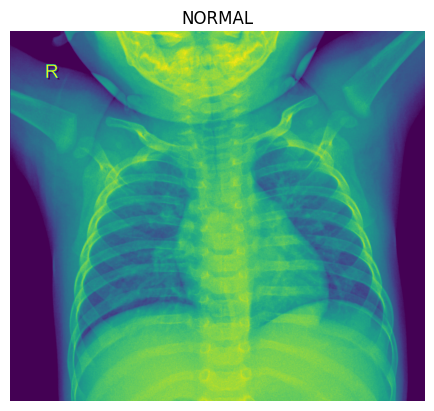

In [29]:
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## Model 1: EfficientNet - limited data preprocessing

In [14]:
import tensorflow as tf

In [40]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=(224, 224),
                                                                 label_mode="binary",
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=(224, 224),
                                                                 label_mode="binary",
                                                                 batch_size=32)

Found 5216 files belonging to 2 classes.
Found 5216 files belonging to 2 classes.


In [42]:
for images, labels in train_data.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 71.647064   71.647064   71.647064 ]
   [ 67.27829    67.27829    67.27829  ]
   [ 77.5652     77.5652     77.5652   ]
   ...
   [162.33344   162.33344   162.33344  ]
   [166.80168   166.80168   166.80168  ]
   [171.48807   171.48807   171.48807  ]]

  [[ 75.54906    75.54906    75.54906  ]
   [ 71.564835   71.564835   71.564835 ]
   [ 72.799934   72.799934   72.799934 ]
   ...
   [157.39229   157.39229   157.39229  ]
   [183.5164    183.5164    183.5164   ]
   [180.31848   180.31848   180.31848  ]]

  [[ 73.750465   73.750465   73.750465 ]
   [ 73.780426   73.780426   73.780426 ]
   [ 74.16551    74.16551    74.16551  ]
   ...
   [148.56467   148.56467   148.56467  ]
   [174.16728   174.16728   174.16728  ]
   [179.33168   179.33168   179.33168  ]]

  ...

  [[  0.          0.          0.       ]
   [  7.6079392   7.6079392   7.6079392]
   [ 21.785803   21.785803   21.785803 ]
   ...
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [ 

In [43]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [45]:
# 1. Create base model w/ tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# Not including the top layer b/c we want to add in a different dense
# layer which depends on the number of data inputs

# 2. Freeze base model (so underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 5. Pass inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of base model (aggregate all most information, reduce num of computations)
# like maxpooling layers
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalaveragePooling2D: {x.shape}")

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# 8. Combine inputs w/ outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit model
history_1  = model_1.fit(train_data,
                         epochs=5,
                         steps_per_epoch=len(train_data),
                         validation_data=test_data,
                         validation_steps=len(test_data),
                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="pneumonia_models")])


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalaveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/pneumonia_models/20231017-213129
Epoch 1/5
163/163 [==============================] - 90s 444ms/step - loss: 0.2649 - accuracy: 0.9015 - val_loss: 0.1637 - val_accuracy: 0.9419
Epoch 2/5
163/163 [==============================] - 69s 418ms/step - loss: 0.1550 - accuracy: 0.9448 - val_loss: 0.1261 - val_accuracy: 0.9569
Epoch 3/5
163/163 [==============================] - 69s 419ms/step - loss: 0.1278 - accuracy: 0.9546 - val_loss: 0.1075 - val_accuracy: 0.9640
Epoch 4/5
163/163 [==============================] - 69s 416ms/step - loss: 0.1156 - accuracy: 0.9607 - val_loss: 0.0955 - val_accuracy: 0.9686
Epoch 5/5
163/163 [==============================] - 70s 415ms/step - loss: 0.1002 - accuracy: 0.9655 - val_loss: 0.0874 - val_accuracy: 0.9709


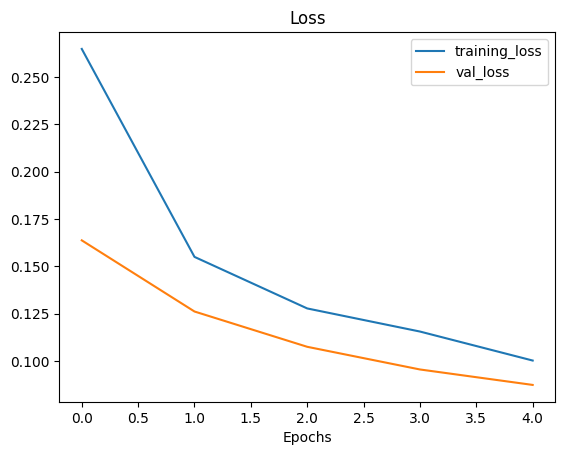

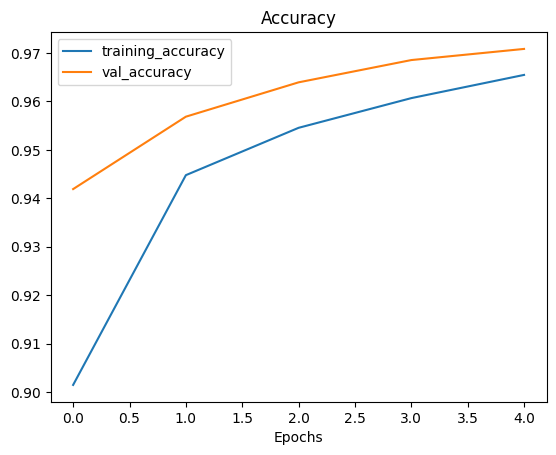

In [46]:
plot_loss_curves(history_1)